<a href="https://colab.research.google.com/github/kbm1959/jupyter/blob/main/optimized_neuralnetwork_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import Libraries

In [1]:
# import pandas to import csv files
import pandas

# import matplotlib to show images
import matplotlib.pyplot as plt

# import pytorch libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset

import imageio.v2 as imageio
import numpy as np
from pathlib import Path

# Mount Google Drive

In [2]:
# mount drive to access data files
from google.colab import drive
drive.mount('./mount')

Mounted at ./mount


In [ ]:
df = pandas.read_csv('mount/My Drive/Colab Notebooks/neuralnetworks/mnist_data/mnist_train.csv', header=None)


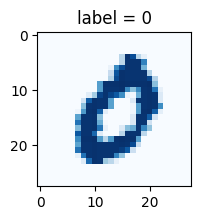

In [ ]:
# get data from dataframe
row = 37
data = df.iloc[row]

# label is the first value
label = data[0]

# image data is the remaining 784 values
img = data[1:].values.reshape(28,28)

plt.figure(figsize=(2,2))
plt.title("label = " + str(label))
plt.imshow(img, interpolation='none', cmap='Blues')
plt.show()

# Define neural network


In [84]:
class Classifier(nn.Module):

  def __init__(self):
    # initialize parent roch class
    super().__init__()

    # define neural network layers
    self.model = nn.Sequential(
        nn.Linear(784,200),
        nn.Sigmoid(),
        nn.Linear(200,10),
        nn.Sigmoid()
    )

    # counter and accumulator for progress
    self.counter = 0
    self.progress = []


    # create loss funtion
    self.loss_function = nn.MSELoss()

    # create optimizer, using simple stochastic gradient descent
    self.optimiser = torch.optim.Adam(self.parameters())

    pass

  def forward(self, inputs):
    # simply run model
    return self.model(inputs)

  def train(self, inputs, targets):
    # calculate the output of the network
    outputs = self.forward(inputs)

    # calculate loss
    loss = self.loss_function(outputs, targets)

    # zero gradients, perform a backward pass and update the weights
    self.optimiser.zero_grad()
    loss.backward()
    self.optimiser.step()

    # increase counter and accumulate error every 10 cycles
    self.counter += 1
    if (self.counter % 10 == 0):
      self.progress.append(loss.item())
      pass

    if (self.counter % 10000 == 0):
      print("counter = ", self.counter)
      pass

  def plot_progress(self):
    df = pandas.DataFrame(self.progress, columns = ['loss'])
    df.plot(ylim=(0,1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0,0.25,0.5))
    pass


In [4]:
class MnistDataset(Dataset):

  def __init__(self,csv_file):
    self.data_df = pandas.read_csv(csv_file, header=None)
    pass

  def __len__(self):
    return len(self.data_df)

  def __getitem__(self, index):
    # image target (label)
    label = self.data_df.iloc[index,0]
    target = torch.zeros((10))
    target[label] = 1.0

    # image data,n normalized from 0-255 to 0-1
    image_values = torch.FloatTensor(self.data_df.iloc[index,1:].values) / 255.0

    # return label, image data tensor and target tensor
    return label, image_values, target

  def plot_image(self, index):
    arr = self.data_df.iloc[index,1:].values.reshape(28,28)
    plt.figure(figsize=(2,2))
    plt.title("label = " + str(self.data_df.iloc[index,0]))
    plt.imshow(arr, interpolation='none', cmap='Blues')
    pass

  pass


In [5]:
class ImportMyDataset(MnistDataset):

  def __init__(self,img_dir):
    arr = np.zeros((1,28*28+1))
    for file in Path(img_dir).iterdir():
      if not file.is_file():
        continue
      if str(file).lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):
        label = int(Path(file).stem[0])
        number = 255 - imageio.imread(file, mode='L')
        arr = np.append(arr , np.concatenate((np.array([label]),number.reshape(28*28))).reshape(1,28*28+1), axis=0)
    self.data_df = pandas.DataFrame(arr[1:],dtype=int)
    pass



In [7]:
mnist_dataset = MnistDataset('mount/My Drive/Colab Notebooks/neuralnetworks/mnist_data/mnist_train.csv')

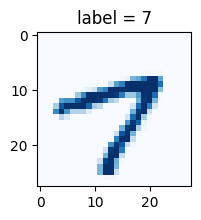

In [8]:
mnist_dataset.plot_image(101)

# Train the neural network

In [85]:
%%time
# create neural network
C = Classifier()

# train network on MNIST data set
epochs = 3
for i in range(epochs):
  print('Training epoch ', i+1, ' of ', epochs)
  for label, image_data_tensor, target_tensor in mnist_dataset:
    C.train(image_data_tensor, target_tensor)
    pass



Training epoch  1  of  3
counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
Training epoch  2  of  3
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
Training epoch  3  of  3
counter =  130000
counter =  140000
counter =  150000
counter =  160000
counter =  170000
counter =  180000
CPU times: user 13min 38s, sys: 1.62 s, total: 13min 39s
Wall time: 13min 46s


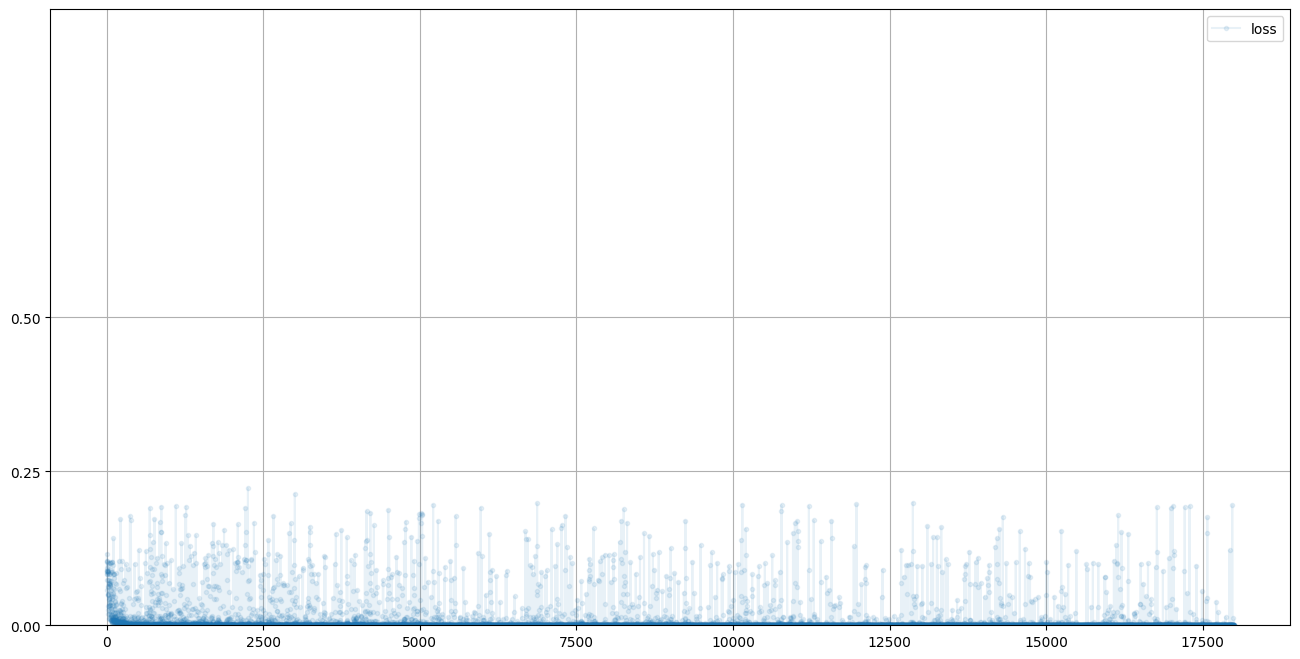

In [86]:
# plot classifier error
C.plot_progress()

# Test the network with Mnist Test Data

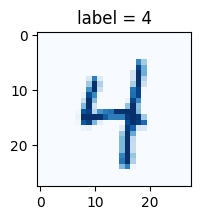

In [87]:
# load MNIST test data
mnist_test_dataset = MnistDataset('mount/My Drive/Colab Notebooks/neuralnetworks/mnist_data/mnist_test.csv')
# test_dataset_small = MnistDataset('mount/My Drive/Colab Notebooks/neuralnetworks/mnist_data/mnist_test_10.csv')

# pick a record
record = 19

# plot image and correct label
mnist_test_dataset.plot_image(record)


<Axes: >

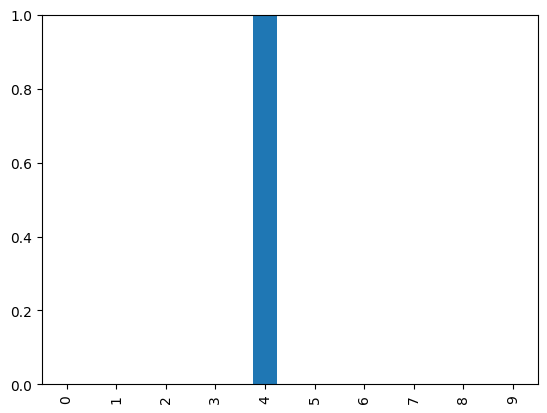

In [88]:
image_data = mnist_test_dataset[record][1]

# query from trained network
output = C.forward(image_data)

# plot output tensor
pandas.DataFrame(output.detach().numpy()).plot(kind='bar', legend=False, ylim=(0,1))

# Test the network with my own data

In [89]:
# load my test data
my_data=ImportMyDataset("mount/My Drive/Colab Notebooks/MNIST_Data/Hannah/thumbs")

<Axes: >

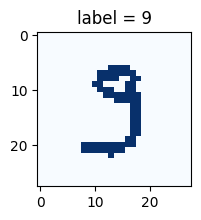

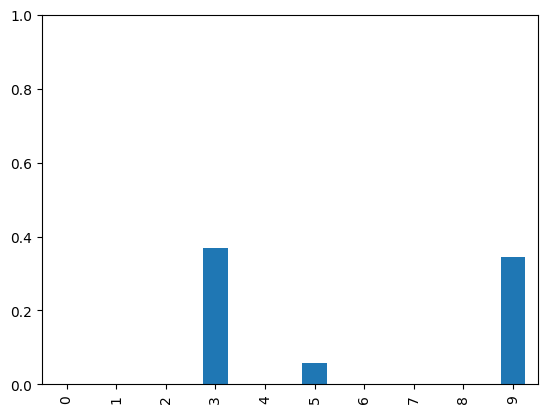

In [90]:
# pick a record
record = 9

# plot image and correct label
my_data.plot_image(record)
image_data = my_data[record][1]

# query from trained network
output = C.forward(image_data)

# plot output tensor
pandas.DataFrame(output.detach().numpy()).plot(kind='bar', legend=False, ylim=(0,1))

In [91]:
# test trained neural network on training data

score = 0
items = 0
for label, image_data_tensor, target_tensor in mnist_test_dataset:
  answer = C.forward(image_data_tensor).detach().numpy()
  if (answer.argmax() == label):
    score += 1
  items += 1
  pass

print("accuracy = ", score/items)


accuracy =  0.9711


In [92]:
# test trained neural network on my data

score = 0
items = 0
for label, image_data_tensor, target_tensor in my_data:
  answer = C.forward(image_data_tensor).detach().numpy()
  if (answer.argmax() == label):
    score += 1
  items += 1
  pass

print("accuracy = ", score/items)


accuracy =  0.5
